In [1]:
# This script requires you to use a DESI kernel

%matplotlib inline
# matplotlib widget doesn't seem to work
# %matplotlib widget
import sys
import math
import logging
import random
import numpy as np
import psycopg2
import psycopg2.extras
from matplotlib import pyplot

from mosthosts_desi import MostHostsDesi
from desi_specinfo import TargetNotFound, SpectrumInfo

logger = logging.getLogger("main")
ch = logging.StreamHandler(sys.stderr)
logger.addHandler(ch)
formatter = logging.Formatter(
    f"[%(asctime)s - %(levelname)s] - %(message)s"
)
ch.setFormatter(formatter)
logger.setLevel( logging.INFO )

In [2]:
# Replace these next two lines with something that sets dbuser and dbpasswd to the
#  right value.  It can be as simple as
#    dbuser = 'desi'
#    dbpasswd = '...'
#  with the right thing in place of ...
#  (Just don't save the password to a public git archive.)
with open("/global/homes/r/raknop/secrets/decatdb_desi_desi") as ifp:
    (dbuser, dbpasswd) = ifp.readline().strip().split()
    
# Read in the MostHosts data with info on what's been observed by desi
mosthosts = MostHostsDesi(dbuser=dbuser, dbpasswd=dbpasswd, logger=logger)

[2022-03-04 07:18:51,868 - INFO] - Loading mosthosts table...
[2022-03-04 07:18:53,127 - INFO] - ...mosthosts table loaded.
[2022-03-04 07:18:53,183 - INFO] - Read dataframes from pkl files


In [18]:
# Which SN do we want to look at?  Make it None to choose a random one.
# This name has to match the name used in SkyPortal (TNS name first,
# then IAU name if TNS doesn't exist, then PTFIPTF if IAU doesn't
# exist, then whatever's in the snname field.  This is what is in
# the "spname" index of mosthosts.df and mosthosts.haszdf.)
sntoshow = '2004ij'
# sntoshow = None

if sntoshow is None:
    sne = mosthosts.haszdf.index.unique( level=0 )
    dex = random.randint(0, len(sne)-1)
    spname = sne[dex]
else:
    spname = sntoshow

logger.info( f'Going to look at spectra for {spname}' )


[2022-03-04 10:32:48,216 - INFO] - Going to look at spectra for 2004ij


In [19]:
sub = mosthosts.haszdf.loc[ spname, : ]
logger.info( f'There are {len(sub)} hosts with 1 or more desi spectra.' )

allhostdata = []

for index, ra, dec in zip( sub.index, sub['ra'], sub['dec'] ):
    try:
        print( f'{index} {ra} {dec}' )
        index = int(index[0])
        specinfo = SpectrumInfo( ra, dec, desipasswd=dbpasswd, logger=logger)
        allhostdata.append( specinfo )
        print( f'Host {index} of {spname} at {ra:.4f}, {dec:.4f} has {len(specinfo.targetids)} spectra' )
        for targetid in specinfo.targetids:
            targetinfo = specinfo.info_for_targetid( targetid )
            for info in targetinfo:
                print( f'  targetid={targetid}, tileid={info["tileid"]}, petal_loc={info["petal_loc"]}, '
                       f'device_loc={info["device_loc"]}, night={info["night"]}, z={info["z"]:.3f}±{info["zerr"]:.3f}',
                       f'zwarn={info["zwarn"]}' )
                print( f'   filename={info["filename"]}' )
    except TargetNotFound as ex:
        logger.error( f'No spectra found for host {index} of {mosthost_name} at ({ra:.4f}, {dec:.4f})' )
        continue

[2022-03-04 10:32:54,513 - INFO] - There are 2 hosts with 1 or more desi spectra.
[2022-03-04 10:32:54,535 - INFO] - Looking for daily spectra at (20.2986, -0.9191)
[2022-03-04 10:32:54,580 - INFO] - Looking for daily spectra at (20.2986, -0.9191)


(1, 39627760909420210, 20006, 1, 20210927) 20.2985674296688 -0.919134699768557
Host 1 of 2004ij at 20.2986, -0.9191 has 1 spectra
  targetid=39627760909420210, tileid=20006, petal_loc=1, device_loc=230, night=20210927, z=-0.002±0.000 zwarn=1570
   filename=daily/tiles/cumulative/20006/20210927/redrock-1-20006-thru20210927.fits
  targetid=39627760909420210, tileid=25762, petal_loc=1, device_loc=3, night=20211009, z=0.217±0.000 zwarn=0
   filename=daily/tiles/cumulative/25762/20211009/redrock-1-25762-thru20211009.fits
(1, 39627760909420210, 25762, 1, 20211009) 20.2985674296688 -0.919134699768557
Host 1 of 2004ij at 20.2986, -0.9191 has 1 spectra
  targetid=39627760909420210, tileid=20006, petal_loc=1, device_loc=230, night=20210927, z=-0.002±0.000 zwarn=1570
   filename=daily/tiles/cumulative/20006/20210927/redrock-1-20006-thru20210927.fits
  targetid=39627760909420210, tileid=25762, petal_loc=1, device_loc=3, night=20211009, z=0.217±0.000 zwarn=0
   filename=daily/tiles/cumulative/25762

INFO:spectra.py:285:read_spectra: iotime 1.109 sec to read coadd-1-20006-thru20210927.fits at 2022-03-04T10:33:03.598448
INFO:spectra.py:285:read_spectra: iotime 1.343 sec to read coadd-1-25762-thru20211009.fits at 2022-03-04T10:33:05.487310
INFO:spectra.py:285:read_spectra: iotime 0.506 sec to read coadd-1-20006-thru20210927.fits at 2022-03-04T10:33:06.567570
INFO:spectra.py:285:read_spectra: iotime 0.557 sec to read coadd-1-25762-thru20211009.fits at 2022-03-04T10:33:07.792039


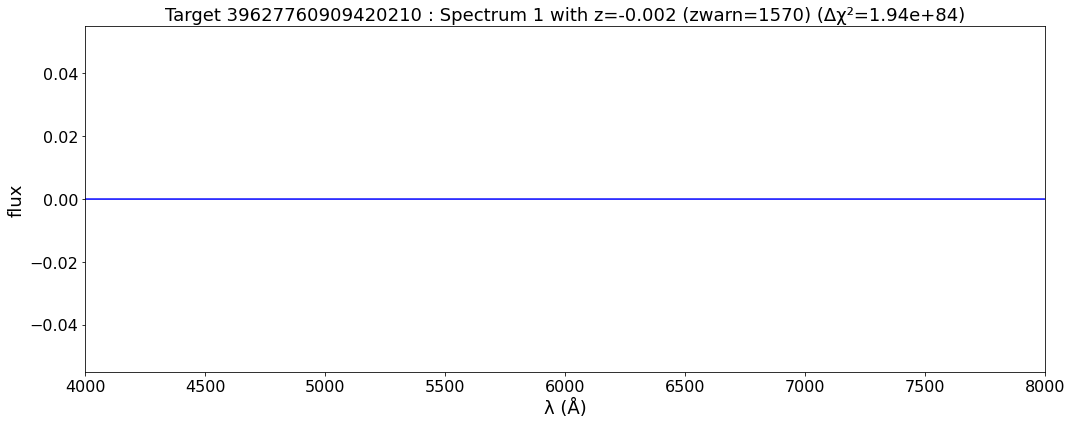

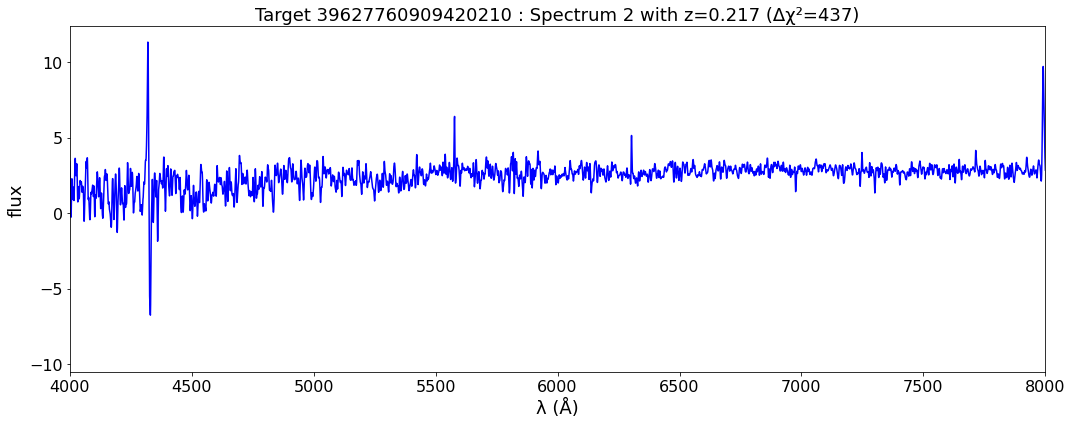

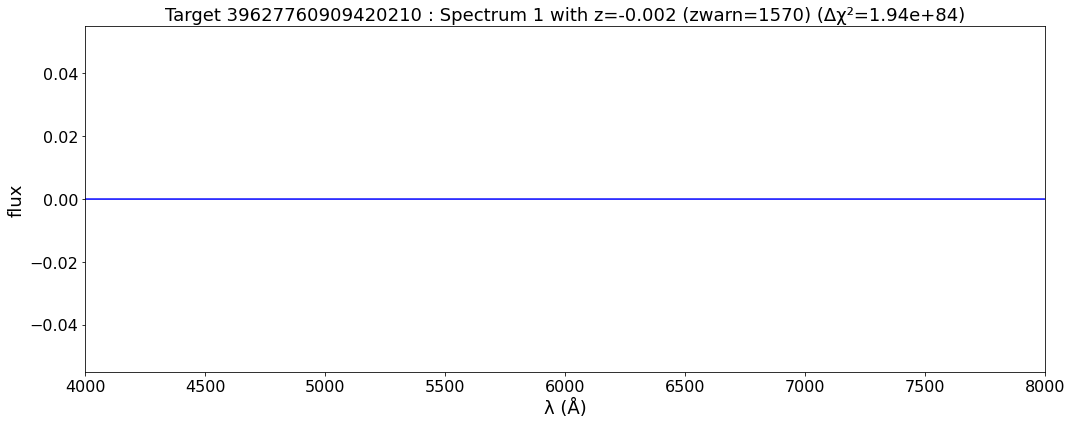

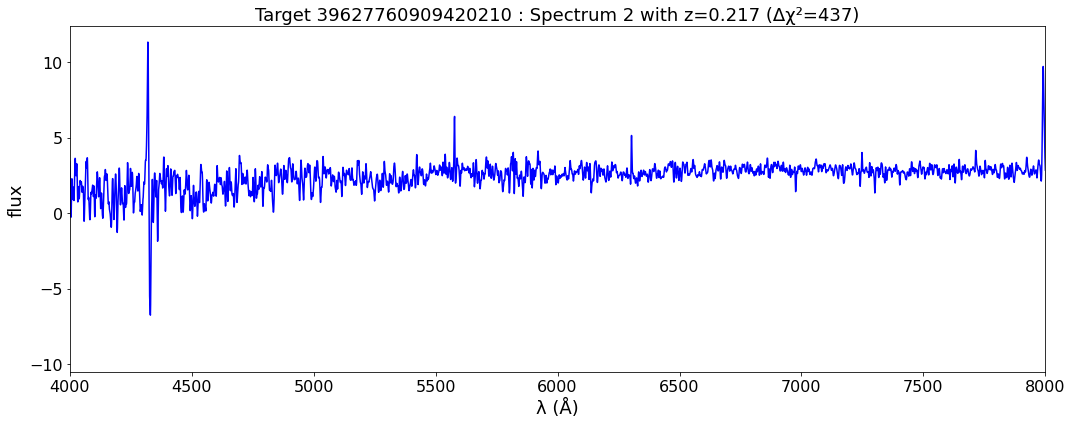

In [20]:
# Plot limits.  Make them None to autoscale
fmin = None
fmax = None
λmin = 4000
λmax = 8000
gausssmooth = 2

targnum = -1
for hostcollection in allhostdata:
    for targetid in hostcollection.targetids:
        targnum += 1
        infos = hostcollection.info_for_targetid( targetid )
        spectra = hostcollection.get_spectra( targetid, smooth=gausssmooth )
        specnum = 0
        for info, spec in zip( infos, spectra):
            specnum += 1
            fig = pyplot.figure( figsize=(15,6), tight_layout=True )
            ax = fig.add_subplot( 1, 1, 1 )
            title = ( f'Target {targetid} : Spectrum {specnum} '
                      # f'Tile {spec["tileid"]} on night {spec["night"]} '
                      f'with z={info["z"]:.3f}' )
            if info["zwarn"] != 0:
                title += f' (zwarn={info["zwarn"]})'
            title += f' (Δχ²={info["deltachi2"]:.3g})'
            ax.set_title( title, fontsize=18 )
            ax.set_xlabel( 'λ (Å)', fontsize=18 )
            ax.set_ylabel( 'flux', fontsize=18 )
            ax.tick_params( axis='both', labelsize=16 )
            if λmin is not None:
                ax.set_xlim( λmin, λmax )
            if fmin is not None:
                ax.set_ylim( fmin, fmax )
            λ = spec.wave['brz']
            flux = spec.flux['brz'][0, :]
            ax.plot( λ, flux, 'b' )
            fig.show()
